## Preprocessing for LSTM: Blobdetection and Cutting

In [2]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool, cpu_count

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool
import cv2

In [3]:
df_filtered = pd.read_pickle("DataStudyCollection/df_lstm.pkl")

In [4]:
df_filtered.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image,IsMax,MaxRepetition
291980,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0
291981,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0
291982,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0
291983,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0
291984,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0


In [5]:
df_filtered.Image = df_filtered.Image.apply(lambda x: x.reshape(27, 15))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.clip(min=0, max=255))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.astype(np.uint8))
df_filtered["ImageSum"] = df_filtered.Image.apply(lambda x: np.sum(x))

In [6]:
#LSTMs new Blob detection (only detect, if there are blobs)
def detect_blobs(image):
    #image = image.reshape(27, 15)
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = image
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 200, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 8 and cv2.contourArea(a) < 255]
    lstBlob  = []
    lstMin = []
    lstMax = []
    count = 0
    return len(contours) > 0

In [7]:
%%time
pool = Pool(cpu_count() - 1)
temp_blobs = pool.map(detect_blobs, df_filtered.Image)
pool.close()

CPU times: user 3.42 s, sys: 1.14 s, total: 4.57 s
Wall time: 4.94 s


In [8]:
df_filtered["ContainsBlobs"] = temp_blobs

In [9]:
#Label if knuckle or finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df_filtered['InputMethod'] = df_filtered.apply(f, axis=1)

In [10]:
df_filtered.index = range(len(df_filtered))

In [11]:
%%time
# trim image sequences down to only between first and last detected blob
UserIDs = []
TaskIDs = []
VersionIDs = []
Blobs = []
for userID in df_filtered.userID.unique():
    print(userID)
    for TaskID in df_filtered[df_filtered.userID == userID].TaskID.unique():
        for VersionID in df_filtered[(df_filtered.userID == userID) & (df_filtered.TaskID == TaskID)].VersionID.unique():
            first_blob = -1
            last_blob = -1
            for index, row in df_filtered[(df_filtered.userID == userID) & (df_filtered.TaskID == TaskID) & (df_filtered.VersionID == VersionID)].iterrows():
                if row.ContainsBlobs:
                    last_blob = index
                    if first_blob == -1:
                        first_blob = index
            if first_blob >= 0 and last_blob >= 0:
                UserIDs.append(userID)
                TaskIDs.append(TaskID)
                VersionIDs.append(VersionID)
                Blobs.append(df_filtered[(df_filtered.userID == userID) & (df_filtered.TaskID == TaskID) & (df_filtered.VersionID == VersionID) & (df_filtered.index >= first_blob) & (df_filtered.index <= last_blob)].Image.tolist())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
CPU times: user 4min 7s, sys: 424 ms, total: 4min 8s
Wall time: 4min 8s


In [12]:
UserIDs = np.array(UserIDs, dtype=np.int64)
TaskIDs = np.array(TaskIDs, dtype=np.int64)
VersionIDs = np.array(VersionIDs, dtype=np.int64)

In [13]:
df_lstm_all = pd.DataFrame()
df_lstm_all["userID"] = UserIDs
df_lstm_all["TaskID"] = TaskIDs
df_lstm_all["VersionID"] = VersionIDs
df_lstm_all["Blobs"] = Blobs
df_lstm_all.Blobs = df_lstm_all.Blobs.map(np.array)
df_lstm_all.head()

,userID,TaskID,VersionID,Blobs
0,1,0,3,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,1,0,5,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,1,0,6,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 239,..."
3,1,0,7,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,1,0,8,"[[[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0..."


In [33]:
df_lstm_all.head()

,userID,TaskID,VersionID,Blobs,BlobCount,GestureOnly
0,1,0,3,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",38,0
1,1,0,5,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",57,0
2,1,0,6,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 239,...",41,0
3,1,0,7,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",20,0
4,1,0,8,"[[[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0...",41,0


In [34]:
df_lstm_all["Length"] = df_lstm_all.Blobs.apply(lambda x: x.shape[0])

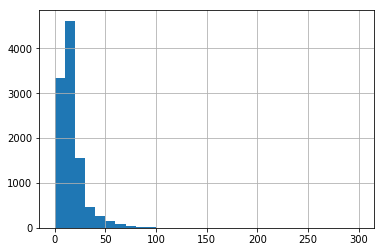

In [43]:
df_lstm_all.Length.hist(range=(0,300), bins=30)

In [46]:
len(df_lstm_all[df_lstm_all.Length > 50]) / len(df_lstm_all)

0.02870949403069926

In [52]:
df_lstm_all.Length.describe().round(1)

count    10554.0
mean        15.9
std         13.6
min          1.0
25%          8.0
50%         13.0
75%         19.0
max        301.0
Name: Length, dtype: float64

In [14]:
lengths = []
for index, row in df_lstm_all.iterrows():
    lengths.append(row.Blobs.shape[0])
df_lstm_all["BlobCount"] = lengths
# add a column for pure gesture recognition without finger/knuckle
df_lstm_all["GestureOnly"] = df_lstm_all.TaskID % 17

In [15]:
df_lstm_all.BlobCount.describe()

count    10554.000000
mean        15.906576
std         13.605214
min          1.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        301.000000
Name: BlobCount, dtype: float64

In [16]:
df_lstm_all.groupby(df_lstm_all.GestureOnly)["BlobCount"].agg(["mean", "std"])

,mean,std
GestureOnly,,
0,11.421429,8.940925
1,13.618683,13.864708
2,8.852596,6.315931
3,8.672913,5.580500
4,9.828767,6.793559
5,9.211221,6.861675
6,14.622496,8.338379
7,13.684524,13.263753
8,20.397129,12.916920


In [17]:
# filter on gesture lengths
print("before: %s" % len(df_lstm_all))
df_lstm = df_lstm_all[(df_lstm_all.BlobCount <= 100) & (df_lstm_all.BlobCount >= 5)]
print("after: %s" % len(df_lstm))
print("ratio: %s" % ((len(df_lstm_all) - len(df_lstm)) / len(df_lstm_all) * 100))

before: 10554
after: 9193
ratio: 12.895584612469206


In [18]:
df_lstm.BlobCount.describe()

count    9193.000000
mean       17.678995
std        12.059369
min         5.000000
25%        10.000000
50%        15.000000
75%        20.000000
max        97.000000
Name: BlobCount, dtype: float64

In [19]:
lengths = []
for index, row in df_lstm.iterrows():
    lengths.append(row.Blobs.shape[0])

In [20]:
df_lstm["BlobCount"] = lengths

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
df_lstm.BlobCount.describe()

count    9193.000000
mean       17.678995
std        12.059369
min         5.000000
25%        10.000000
50%        15.000000
75%        20.000000
max        97.000000
Name: BlobCount, dtype: float64

In [23]:
def lerp(a, b, c=0.5):
    return c * b + (1.0 - c) * a

#Svens new Blob detection
def detect_blobs_return_old(image, task):
    #image = e.Image
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = np.copy(image)
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 205, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 8 and cv2.contourArea(a) < 255]
    lstBlob  = []
    lstCenter = []
    lstMin = []
    lstMax = []
    count = 0
    contours.sort(key=lambda a: cv2.contourArea(a))
    if len(contours) > 0:
        # if two finger or knuckle
        cont_count = 2 if task in [1, 6, 7, 18, 23, 24] and len(contours) > 1 else 1
        for i in range(1, cont_count + 1):
            max_contour = contours[-1 * i]
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            M = cv2.moments(max_contour)
            cX = int(M["m10"] / M["m00"]) - 1
            cY = int(M["m01"] / M["m00"]) - 1
            #croped_im = np.zeros((27,15))
            blob = large[max(ymin - 1, 0):min(ymax + 1, large.shape[0]),max(xmin - 1, 0):min(xmax + 1, large.shape[1])]
            #croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
            #return (1, [croped_im])
            lstBlob.append(blob)
            lstCenter.append((cY, cX))
            lstMin.append(xmax-xmin)
            lstMax.append(ymax-ymin)
            count = count + 1
        return (count, lstBlob, lstCenter)
    else:
        return (0, [np.zeros((29, 19))], 0, 0)

In [24]:
# descides whether or not a normalization is neccessary
# and cuts or adds zeros
def normalize_blobs(blobs, new_len=50):
    new_count = new_len - blobs.shape[0]
    if new_count == 0:
        return blobs
    elif new_count > 0:
        temp = np.array([np.zeros((27, 15))] * new_count)
        return np.append(blobs, temp, axis=0)
    else:
        return blobs[0:new_len]

In [25]:
%%time
# normalizes all image sequences
df_lstm_norm = df_lstm.copy(deep=True)
new_blobs = []
for index, row in df_lstm.iterrows():
    new_blobs.append(normalize_blobs(row.Blobs, 50))

df_lstm_norm.Blobs = new_blobs

lengths = []
for index, row in df_lstm_norm.iterrows():
    lengths.append(row.Blobs.shape[0])
df_lstm_norm["BlobCount"] = lengths

CPU times: user 3.24 s, sys: 556 ms, total: 3.8 s
Wall time: 3.8 s


In [26]:
df_lstm_norm.BlobCount.describe()

count    9193.0
mean       50.0
std         0.0
min        50.0
25%        50.0
50%        50.0
75%        50.0
max        50.0
Name: BlobCount, dtype: float64

In [27]:
df_lstm_norm.to_pickle("DataStudyCollection/df_lstm_norm50.pkl")

In [28]:
df_lstm_norm.head()

,userID,TaskID,VersionID,Blobs,BlobCount,GestureOnly
0,1,0,3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",50,0
1,1,0,5,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",50,0
2,1,0,6,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",50,0
3,1,0,7,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",50,0
4,1,0,8,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0...",50,0


In [29]:
print("finished")

finished
